In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Here are helping function.

if the image below shows plain white or black, please re-run the whole program from the top cell

In [26]:
def computer_hist(image, size):
    pixels = image.ravel()
    l = [0] * size    
    for pixel in pixels:
        l[pixel] += 1
    return l

def computer_probability(l, size):
    arr = []
    for pixel in l:
        arr.append(pixel/size)
    return arr

def cluster_probability1(t, probability):
    p = 0
    for i in range(0, t + 1):
        p += probability[i]
    return p

def cluster_probability2(t, probability, size):
    p = 0
    for i in range(t + 1, size):
        p += probability[i]
    return p

def mean1(t, w1, probability):
    mean = 0
    total = 0
    if w1 == 0:
        return 0
    for i in range(0, t + 1):
        total += i * probability[i]
    mean = total / w1
    return mean

def mean2(t, w2, probability, size):
    mean = 0
    total = 0
    if w2 == 0:
        return 0
    for i in range(t + 1, size):
        total += i * probability[i]
    mean = total / w2
    return mean

def otsu_threshold(initial_variance, size, p):
    #we take 0 as initial threshold
    threshold = 0
    for i in range(1, size):
        w1 = cluster_probability1(i, p)
        w2 = cluster_probability2(i, p, size)
        u1 = mean1(i, w1, p)
        u2 = mean2(i, w2, p, size)
        tmp_variance = w1 * w2 * (u1 - u2) ** 2
        if tmp_variance > initial_variance:
            initial_variance = tmp_variance
            threshold = i
    return threshold

def apply_threshold(image, threshold, pixel_value1, pixel_value2):
    new_img = np.copy(image)
    for row in range(new_img.shape[0]):
        for col in range(new_img.shape[1]):
            if new_img[row][col] >= threshold:
                new_img[row][col] = pixel_value1
            else:
                new_img[row][col] = pixel_value2
    return new_img
                

def median_filter(image, window_size):
    tmp = []
    col = image.shape[0]
    row = image.shape[1]
    index = window_size // 2
    final_img = np.zeros((col, row), dtype=int)
    tmp_img = image
    #add zeros to the edge of image
    for n in range(1, index+1):
        zero_edge_col = np.zeros(col+(n-1)*2, dtype=int)
        tmp_img = np.hstack((tmp_img, np.atleast_2d(zero_edge_col).T))
        tmp_img = np.hstack((np.atleast_2d(zero_edge_col).T, tmp_img))
        zero_edge_row = np.zeros(row+2*n, dtype=int)
        tmp_img = np.vstack((tmp_img, zero_edge_row))
        tmp_img = np.vstack((zero_edge_row, tmp_img))
    
    for c in range(1, col+1):
        for r in range(1, row+1):
            for s in range(window_size):
                for i in range(window_size):
                    pixel = tmp_img[c+s-index][r+i-index]
                    tmp.append(pixel)
    
            tmp.sort()
            median = len(tmp) // 2
            final_img[c-1][r-1] = tmp[median]
            tmp = []
    return final_img

def get_neighbors(col, row, labels):
    neighbors = []
    for i in range(0,3):
        for j in range(0,3): 
            if 0 <= col-1+i < labels.shape[0] and 0 <= row-1+j < labels.shape[1]:
                if labels[col-1+i][row-1+j] != 0:
                    neighbors.append(labels[col-1+i][row-1+j])
    return neighbors

def find_label(linked, label):
    lab = min(linked[label])
    return lab

def connected_component_labeling(image):
    background_colour = 0
    col = image.shape[0]
    row = image.shape[1]
    linked = {}
    index = 0
    labels = np.zeros((col, row), dtype=int)
    
    #First pass
    for r in range(0, row):
        for c in range(0, col):
            if image[c][r] != background_colour:
                neighbors = get_neighbors(c, r, labels)
                if not neighbors:
                    index += 1
                    linked[index] = index
                    labels[c][r] = index
                else:
                    labels[c][r] = min(neighbors)
                    for label in neighbors:
                        s = set()
                        if isinstance(linked[label], int):
                            s.add(linked[label])
                        else:
                            s = set(linked[label])
                        linked[label] = s.union(neighbors)
                        
    #Second pass
    for r in range(0, row):
        for c in range(0, col):
            if image[c][r] != background_colour:
                labels[c][r] = find_label(linked, labels[c][r])
    
    
    return labels

#find the threshold area by growth rate
def find_threshold_growth(l):
    size = len(l)
    index = 0
    for i in range(1, size):
        if l[i-1] == 0:
            continue
        growth_rate = (l[i]-l[i-1])/l[i-1]
        if growth_rate > 1.8:
            index = i
            break
    return index

#find the threshold area area by maximising the inter-class variance
def find_threshold_var(l):
    size = len(l)
    total = 0
    for i in l:
        total += i
    mean = total / size
    variance = 0
    tmp = 0
    index = 0
    for i in range(size):
        
        for j in range(i):
            tmp += (l[j] - mean) ** 2 / len(l)
            
        for j in range(i, size):
            tmp += (l[j] - mean) ** 2 / len(l)
        
        if tmp > variance:
            variance = tmp
            index = i
            tmp = 0
    return index

#take 0.15 as error
#if the area >= threshold area * 2 * 0.85
#then considered as overlapping
def check_over_lapping(threshold, area):
    if area >= threshold * 2 * 0.85:
        return True
    return False

def count_cells(min_area, threshold, dic):
    count = 0
    for key in dic:
        if dic[key] >= min_area:
            count += 1
        if check_over_lapping(threshold, dic[key]):
            count += 1
    return count

Task1 Otsu method output

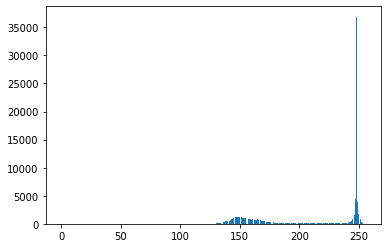

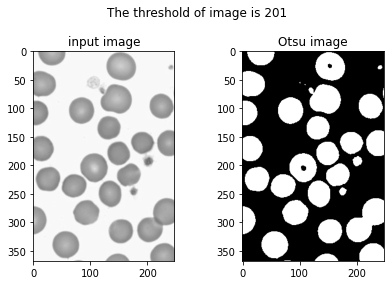

True

In [31]:
image = cv2.imread('c3.jpg', cv2.IMREAD_GRAYSCALE)
l = computer_hist(image, 256)
pixels = image.ravel()
size = pixels.size
p = computer_probability(l, size)

#initial 𝜔𝑖(0) and μ𝑖(0)
w1 = cluster_probability1(0, p)
w2 = cluster_probability2(0, p, 256)
u1 = mean1(0, w1, p)
u2 = mean2(0, w2, p, 256)
variance = w1 * w2 * (u1 - u2) ** 2
#we take 0 as initial threshold
threshold = 0

threshold = otsu_threshold(variance, 256, p)

plt.bar(x=range(0, 256), height=l)
plt.show()

plt.subplot(1,2,1)
plt.title('input image')
plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)

otsu_img = apply_threshold(image, threshold, 0, 255)
copy = image                

plt.subplot(1,2,2)
plt.title('Otsu image')
plt.imshow(otsu_img, cmap = 'gray', vmin = 0, vmax = 255)

plt.suptitle('The threshold of image is ' + str(threshold))

plt.tight_layout()
plt.show()
cv2.imwrite('c3_Otsu.jpg', otsu_img)

Task1 HSV

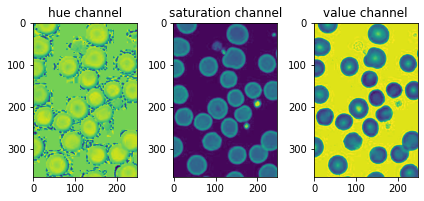

In [32]:
img = cv2.imread('c3.jpg')
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

h, s, v = cv2.split(hsv_img)
plt.subplot(1,3,1)
plt.title('hue channel')
plt.imshow(h)

plt.subplot(1,3,2)
plt.title('saturation channel')
plt.imshow(s)

plt.subplot(1,3,3)
plt.title('value channel')
plt.imshow(v)

plt.tight_layout()
plt.show()

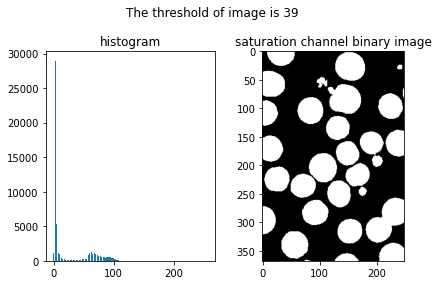

True

In [33]:
arr = computer_hist(s, 256)
plt.subplot(1,2,1)
plt.title('histogram')
plt.bar(x=range(0, 256), height=arr)

s_pixels = s.ravel()
s_size = s_pixels.size
s_p = computer_probability(arr, s_size)

#initial 𝜔𝑖(0) and μ𝑖(0)
s_w1 = cluster_probability1(0, s_p)
s_w2 = cluster_probability2(0, s_p, 256)
s_u1 = mean1(0, s_w1, s_p)
s_u2 = mean2(0, s_w2, s_p, 256)
s_variance = s_w1 * s_w2 * (s_u1 - s_u2) ** 2
s_threshold = 0

s_threshold = otsu_threshold(s_variance, 256, s_p)
s_otsu_img = apply_threshold(s, s_threshold, 255, 0)
plt.subplot(1,2,2)
plt.title('saturation channel binary image')
plt.suptitle('The threshold of image is ' + str(s_threshold))
plt.imshow(s_otsu_img, cmap = 'gray', vmin = 0, vmax = 255)

plt.tight_layout()
plt.show()
cv2.imwrite('c3_HSV.jpg', s_otsu_img)

Task2

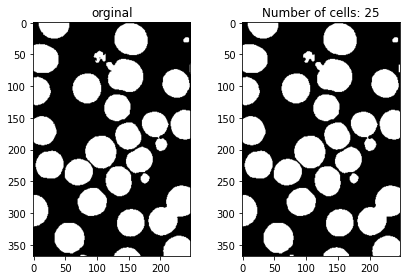

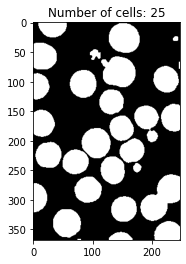

In [35]:
plt.subplot(1,2,1)
plt.title('orginal')
plt.imshow(s_otsu_img, cmap = 'gray', vmin = 0, vmax = 255)

median_img = median_filter(s_otsu_img, 3)

labels = connected_component_labeling(median_img)
#mylist = list(dict.fromkeys(labels.ravel()))
#print(mylist)
dic = {}
l = labels.ravel()
for i in l:
    dic[i] = 0
for i in l:
    dic[i] += 1
    
total = 0
dic[0] = 0
area_list = []

for key in dic:
    total += dic[key]
    area_list.append(dic[key])
    
area_list.sort()
threshold = find_threshold_growth(area_list)
over_lapping = 0
if threshold == 0:
    threshold = find_threshold_var(area_list)
    over_lapping = area_list[threshold]
    min_area = 200
else:
    min_area = area_list[threshold]
    size = (len(area_list) - threshold)
    mean = total / size
    over_lapping = mean * 2

count = count_cells(min_area, over_lapping, dic)
text = 'Number of cells: ' + str(count)

plt.subplot(1,2,2)
plt.title('Number of cells: ' + str(count))
plt.imshow(median_img, cmap = 'gray', vmin = 0, vmax = 255)
plt.tight_layout()
plt.show()

plt.title('Number of cells: ' + str(count))
plt.imshow(median_img, cmap = 'gray', vmin = 0, vmax = 255)
plt.savefig('c3_number_cells.jpg')
